In [1]:
import numpy as np
import pandas as pd
#import pyfolio as pf
import timeit

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from mlfinlab.ensemble import SequentiallyBootstrappedBaggingClassifier
from mlfinlab.sample_weights import get_weights_by_return, get_weights_by_time_decay
from mlfinlab.features.fracdiff import frac_diff_ffd
from mlfinlab.feature_importance.orthogonal import get_orthogonal_features, feature_pca_analysis
from mlfinlab.feature_importance import (mean_decrease_impurity, 
                                        mean_decrease_accuracy, 
                                        single_feature_importance, plot_feature_importance)


import matplotlib.pyplot as plt

import ta

from sklearn.metrics import f1_score

import mlfinlab as ml
%matplotlib inline



Support us on Patreon: https://www.patreon.com/HudsonThames

MlFinLab needs you! We need your help for us to keep on maintaining and implementing academic research based on 
financial machine learning (for open-source). In order for us to continue we need to raise $4000 of monthly donations
via Patreon - by December 2020. If we can't reach our goal, we will need to adopt more of a paid for service. We thought
that the best and least impactful course of action (should we not reach our goal) is to leave the package as open-source
but to make the documentation (ReadTheDocs) a paid for service. This is the ultimate litmus test, if the package is a 
value add, then we need the community to help us keep it going.

Our road map for 2020 is to implement the text book: Machine Learning for Asset Managers by Marcos Lopez de Prado, 
as well as a few papers from the Journal of Financial Data Science. We are hiring a full time developer for 3 months 
to help us reach our goals. The money that you

# Import Data

In [2]:
data = pd.read_csv("Volume_Clean/BTCUSD_volumebars_1000_timestamp.csv")
# Define TimeFrame
data = data[(pd.to_datetime(data['timestamp'], errors='coerce').dt.year >= 2015) & (pd.to_datetime(data['timestamp'], errors='coerce').dt.year <= 2019)]
data = data.dropna()
data = data.reset_index(drop=True)
data.index = pd.to_datetime(data['timestamp'])
data = data.drop('timestamp', axis=1)
data
data = data.dropna()

# Make Stationary

,open,high,low,close,volume,Adj Close_log,frac_diff
timestamp,,,,,,,
2015-01-05 02:00:37.000004,271.990000,273.500000,269.92,272.87,1004.036640,5.608995,0.140771
2015-01-05 02:04:19.000018,272.860000,278.000000,272.28,276.75,1009.833589,5.623115,0.150736
2015-01-05 02:11:13.000002,276.740000,278.000000,274.14,276.58,1007.179874,5.622500,0.140143
2015-01-05 02:21:33.000000,276.510000,278.000000,274.51,274.68,1000.216989,5.615607,0.131045
2015-01-05 02:33:44.000004,274.690000,277.400000,273.22,277.05,1000.577273,5.624198,0.142466
...,...,...,...,...,...,...,...
2019-09-23 06:33:32.372001,10067.000000,10098.000000,9887.10,9895.10,1000.407666,9.199795,0.197736
2019-09-23 14:24:29.992078,9900.000000,9990.887075,9810.00,9820.00,1004.581814,9.192176,0.199992
2019-09-23 14:56:14.924010,9820.000000,9980.000000,9712.00,9949.00,1000.565863,9.205227,0.219518


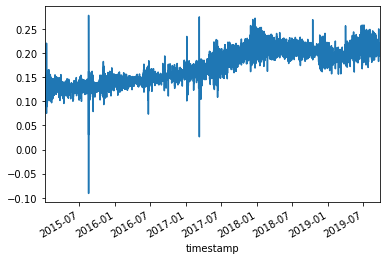

In [3]:

data['Adj Close_log'] = np.log(data['close'])
data['frac_diff'] = frac_diff_ffd(data[['Adj Close_log']], 0.6, thresh=1e-4)
# data['Adj High_log'] = np.log(data['high'])
# data['frac_diff_h'] = frac_diff_ffd(data[['Adj High_log']], 0.5, thresh=1e-3)
# data['Adj Low_log'] = np.log(data['low'])
# data['frac_diff_l'] = frac_diff_ffd(data[['Adj Low_log']], 0.5, thresh=1e-3)
# data['Adj Open_log'] = np.log(data['open'])
# data['frac_diff_o'] = frac_diff_ffd(data[['Adj Open_log']], 0.5, thresh=1e-3)

data = data.dropna()
data['frac_diff'].plot()
data

In [4]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
adf_test(data['frac_diff'])

Results of Dickey-Fuller Test:
Test Statistic                    -2.841975
p-value                            0.052524
#Lags Used                        56.000000
Number of Observations Used    46435.000000
Critical Value (1%)               -3.430491
Critical Value (5%)               -2.861602
Critical Value (10%)              -2.566803
dtype: float64


# Add primary (dumb) signal; Change this part to edit primary model and run from here

# #EMA

In [5]:
data['ema25'] = ta.trend.ema_indicator(close=data["close"], n=25)

# Compute sides
data['side'] = np.nan

long_signals = data['close'] >= data['ema25'] 
short_signals = data['close'] < data['ema25']
data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1


# MA crossover

In [6]:
# # compute moving averages
# fast_window = 10
# slow_window = 20

# data['fast_mavg'] = data['Adj Close_log'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
# data['slow_mavg'] = data['Adj Close_log'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()
# data.head()

# # Compute sides
# data['side'] = np.nan

# long_signals = data['fast_mavg'] >= data['slow_mavg'] 
# short_signals = data['fast_mavg'] < data['slow_mavg'] 
# data.loc[long_signals, 'side'] = 1
# data.loc[short_signals, 'side'] = -1





# Channel breakout

In [7]:
# data['max'] = data['Adj Close_log'].shift(1).rolling(1).max()
# data['min'] = data['Adj Close_log'].shift(1).rolling(1).min()
# data['side'] = np.nan
# long_signals = data['Adj Close_log'] >= data['max']
# short_signals = data['Adj Close_log'] <= data['min']
# data.loc[long_signals, 'side'] = 1
# data.loc[short_signals, 'side'] = -1
# data.fillna(method='ffill', inplace=True)

---------------------------------------------------------------

In [8]:
# copy raw data
raw_data = data.copy()

data['side'] = data['side'].shift(1)
data = data.dropna()
print(data['side'].value_counts())

 1.0    25229
-1.0    21238
Name: side, dtype: int64


In [9]:
data

,open,high,low,close,volume,Adj Close_log,frac_diff,ema25,side
timestamp,,,,,,,,,
2015-01-05 16:03:53.000005,272.100000,272.930000,271.50,271.69,1004.990893,5.604662,0.126464,273.547018,-1.0
2015-01-05 17:19:17.000002,271.730000,273.750000,270.91,271.00,1004.826736,5.602119,0.126324,273.351094,-1.0
2015-01-05 17:30:18.000000,271.310000,271.910000,268.35,269.92,1000.568228,5.598126,0.124488,273.087163,-1.0
2015-01-05 17:50:55.000004,269.920000,269.990000,267.38,268.25,1001.699807,5.591919,0.121306,272.715074,-1.0
2015-01-05 17:54:21.000004,268.100000,268.760000,266.00,266.01,1281.015681,5.583534,0.117467,272.199299,-1.0
...,...,...,...,...,...,...,...,...,...
2019-09-23 06:33:32.372001,10067.000000,10098.000000,9887.10,9895.10,1000.407666,9.199795,0.197736,10091.019591,-1.0
2019-09-23 14:24:29.992078,9900.000000,9990.887075,9810.00,9820.00,1004.581814,9.192176,0.199992,10070.171930,-1.0
2019-09-23 14:56:14.924010,9820.000000,9980.000000,9712.00,9949.00,1000.565863,9.205227,0.219518,10060.851012,-1.0


# Cusum

In [10]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=data['Adj Close_log'], lookback=20)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(data['Adj Close_log'], threshold=daily_vol['2015-01-11':'2019-09-23'].mean()*0.5)

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data['Adj Close_log'], num_days=5)


In [11]:
pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(close=data['Adj Close_log'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=data['side'])

2020-04-03 10:46:28.204620 100.0% apply_pt_sl_on_t1 done after 0.34 minutes. Remaining 0.0 minutes..


In [12]:
labels = ml.labeling.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()

-1.0    1073
 1.0    1020
Name: side, dtype: int64

--------------------------------------------------------------


## Results of Primary Model:
What is the accuracy of predictions from the primary model (i.e., if the sec- ondary model does not filter the bets)? What are the precision, recall, and F1-scores?

In [13]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       765
           1       0.63      1.00      0.78      1328

    accuracy                           0.63      2093
   macro avg       0.32      0.50      0.39      2093
weighted avg       0.40      0.63      0.49      2093

Confusion Matrix
[[   0  765]
 [   0 1328]]

Accuracy
0.634495938843765


C:\Users\TomCLG\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Fit a (secondary) Meta Model; to determine bet size respectively

#### Features

In [14]:
# Momentum
raw_data['mom1'] = raw_data['frac_diff'].pct_change(periods=1)
raw_data['mom2'] = raw_data['frac_diff'].pct_change(periods=2)
raw_data['mom3'] = raw_data['frac_diff'].pct_change(periods=3)
raw_data['mom4'] = raw_data['frac_diff'].pct_change(periods=4)
raw_data['mom5'] = raw_data['frac_diff'].pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['frac_diff'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = raw_data['frac_diff'].rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = raw_data['frac_diff'].rolling(window=15, min_periods=15, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['frac_diff'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['frac_diff'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['frac_diff'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['frac_diff'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['frac_diff'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['frac_diff'].shift(1)
raw_data['log_t2'] = raw_data['frac_diff'].shift(2)
raw_data['log_t3'] = raw_data['frac_diff'].shift(3)
raw_data['log_t4'] = raw_data['frac_diff'].shift(4)
raw_data['log_t5'] = raw_data['frac_diff'].shift(5)

# Get various indicators
raw_data['adx'] = ta.trend.adx(high=raw_data['high'],low=raw_data['low'],close=raw_data["close"])
raw_data['ema14'] = ta.trend.ema_indicator(close=raw_data["frac_diff"], n=14)
raw_data['ema5'] = ta.trend.ema_indicator(close=raw_data["frac_diff"], n=5)
raw_data['ema30'] = ta.trend.ema_indicator(close=raw_data["frac_diff"], n=30)
raw_data['ema90'] = ta.trend.ema_indicator(close=raw_data["frac_diff"], n=90)

raw_data['kama'] = ta.momentum.kama(close=raw_data["frac_diff"])
raw_data['roc'] = ta.momentum.roc(close=raw_data["frac_diff"])
raw_data['atr'] = ta.volatility.average_true_range(high=raw_data['high'], low=raw_data['low'], close=raw_data['close'])

raw_data['percent_change'] = raw_data['frac_diff'].pct_change(periods=1)
raw_data['percent_change'] = raw_data['frac_diff'].pct_change(periods=5)
raw_data['percent_change'] = raw_data['frac_diff'].pct_change(periods=10)
raw_data['ma'] = np.where(raw_data['frac_diff'] > raw_data['frac_diff'].rolling(3).mean(), 1 , 0)
raw_data['ma2'] = np.where(raw_data['frac_diff'] > raw_data['frac_diff'].rolling(13).mean(), 1 , 0)
raw_data['ma3'] = np.where(raw_data['frac_diff'] > raw_data['frac_diff'].rolling(50).mean(), 1 , 0)
raw_data['max'] = raw_data['frac_diff'].shift(1).rolling(5).max()
raw_data['min'] = raw_data['frac_diff'].shift(1).rolling(5).min()
raw_data['maxBreak'] = np.where(raw_data['frac_diff'] > raw_data['max'], 1 ,0)
raw_data['minBreak'] = np.where(raw_data['frac_diff'] < raw_data['min'], 1 ,0)

C:\Users\TomCLG\anaconda3\lib\site-packages\ta\trend.py:567: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
C:\Users\TomCLG\anaconda3\lib\site-packages\ta\trend.py:571: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [15]:
raw_data['ema25'] = ta.trend.ema_indicator(close=raw_data["close"], n=25)

# Compute sides
raw_data['side'] = np.nan

long_signals = raw_data['close'] >= raw_data['ema25'] 
short_signals = raw_data['close'] < raw_data['ema25']
raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [16]:
# Remove look ahead bias
raw_data = raw_data.shift(1)
raw_data.dropna(inplace=True)

### Now get the data at the specified events

In [17]:
raw_data.tail(1)

,open,high,low,close,volume,Adj Close_log,frac_diff,ema25,side,mom1,...,roc,atr,percent_change,ma,ma2,ma3,max,min,maxBreak,minBreak
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-09-23 22:24:06.574,9950.181865,9977.0,9750.0,9750.0,1000.914015,9.185023,0.193298,10036.939396,-1.0,-0.119443,...,-11.848968,184.565318,-0.093099,0.0,0.0,0.0,0.221099,0.197736,0.0,1.0


In [18]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
# X.drop(['open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']

In [19]:
y.value_counts()


1    1328
0     765
Name: bin, dtype: int64

In [20]:
# Split data into training, validation and test sets
X_training_validation = X['2015-01-11':'2019-09-23']
y_training_validation = y['2015-01-11':'2019-09-23']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.25, shuffle=False)

## Sample Weights

In [21]:
return_based_sample_weights = get_weights_by_return(triple_barrier_events.loc[X_train.index], data.loc[X_train.index, 'close'])
time_based_sample_weights = get_weights_by_time_decay(triple_barrier_events.loc[X_train.index], data.loc[X_train.index, 'close'], decay=0.8)

2020-04-03 10:48:45.926082 100.0% num_concurrent_events done after 0.08 minutes. Remaining 0.0 minutes.
2020-04-03 10:48:52.117504 100.0% _apply_weight_by_return done after 0.09 minutes. Remaining 0.0 minutes.
2020-04-03 10:48:58.483829 100.0% num_concurrent_events done after 0.09 minutes. Remaining 0.0 minutes.
2020-04-03 10:49:04.309006 100.0% _get_average_uniqueness done after 0.09 minutes. Remaining 0.0 minutes.


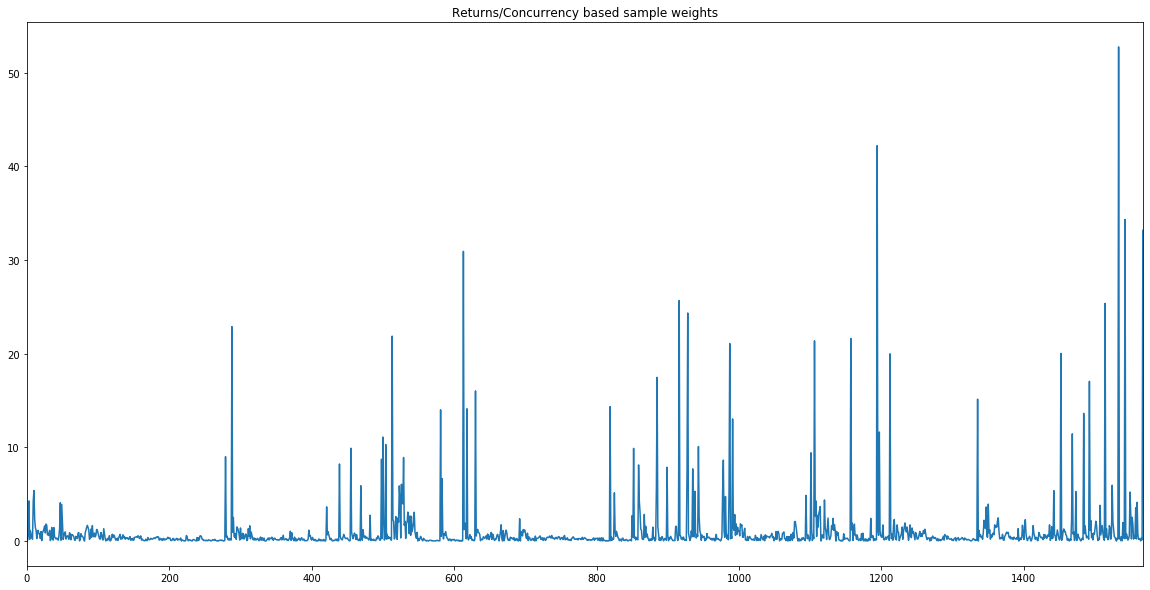

In [22]:
plt.figure(figsize=(20,10))
plt.title('Returns/Concurrency based sample weights')
return_based_sample_weights.reset_index()[0].plot()
plt.show()

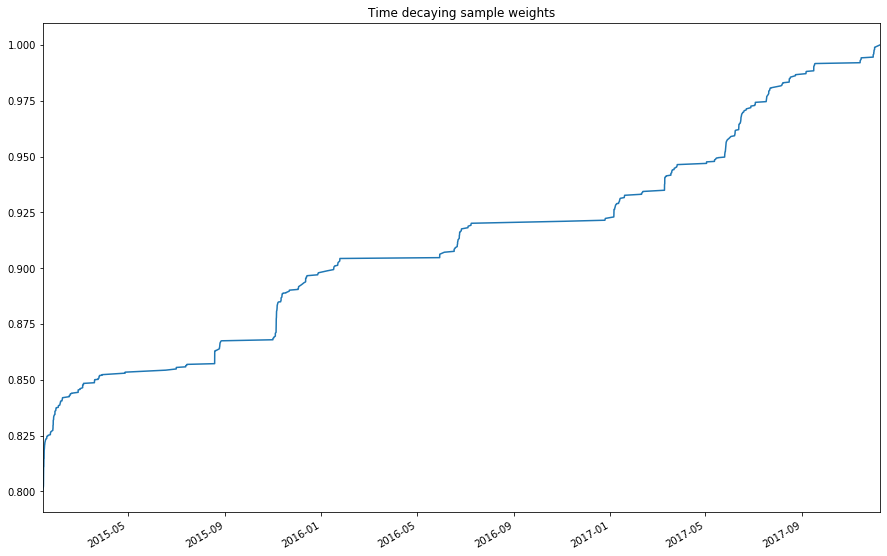

In [23]:
plt.figure(figsize=(15, 10))
plt.title('Time decaying sample weights')
time_based_sample_weights.plot()
plt.show()

# Feature Research, Cross Validation

In [24]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[10, 25, 50, 100, 256, 512]}

In [25]:
cv_gen_standard = KFold(4)
cv_gen_purged = ml.cross_validation.PurgedKFold(n_splits=4, 
                                                samples_info_sets=triple_barrier_events.loc[X_train.index].t1)

# metrics
f1 = f1_score

In [26]:
def perform_grid_search(X_data, y_data, cv_gen, scoring, type='standard'):
    """
    Grid search using Purged CV without using sample weights in fit(). Returns top model and top score
    """
    max_cross_val_score = -np.inf
    top_model = None
    for m_depth in parameters['max_depth']:
        for n_est in parameters['n_estimators']:
            clf_base = DecisionTreeClassifier(criterion='entropy', random_state=42, 
                                              max_depth=m_depth, class_weight='balanced')
            if type == 'standard':
                clf = BaggingClassifier(n_estimators=n_est, 
                                        base_estimator=clf_base, 
                                        random_state=42, n_jobs=-1, 
                                        oob_score=False, max_features=1.)
            elif type == 'random_forest':
                clf = RandomForestClassifier(n_estimators=n_est, 
                                             max_depth=m_depth, 
                                             random_state=42, 
                                             n_jobs=-1, 
                                             oob_score=False, 
                                            criterion='entropy',
                                            class_weight='balanced_subsample', 
                                            max_features=1.)
            elif type == 'sequential_bootstrapping':
                clf = SequentiallyBootstrappedBaggingClassifier(samples_info_sets=triple_barrier_events.loc[X_train.index].t1,
                                                                price_bars = data.loc[X_train.index.min():X_train.index.max(), 'close'],
                                                                n_estimators=n_est, base_estimator=clf_base, 
                                                                random_state=42, n_jobs=-1, oob_score=False,
                                                                max_features=1.)
            temp_score_base = ml.cross_validation.ml_cross_val_score(clf, X_train, y_train, cv_gen, scoring=scoring)
            if temp_score_base.mean() > max_cross_val_score:
                max_cross_val_score = temp_score_base.mean()
                print(temp_score_base.mean())
                top_model = clf
    return top_model, max_cross_val_score

In [27]:
top_model, cross_val_score = perform_grid_search(X_train, y_train, cv_gen_purged, f1, type = 'standard')


0.5121731180162108
0.5304167300159521
0.5492801600785168
0.5567013191895608
0.5652134399143316
0.5735736494518253


In [28]:
def perform_grid_search_sample_weights(X_data, y_data, cv_gen, scoring, type='standard'):
    """
    Grid search using Purged CV using sample weights in fit(). Returns top model and top score
    """
    max_cross_val_score = -np.inf
    top_model = None
    for m_depth in parameters['max_depth']:
        for n_est in parameters['n_estimators']:
            clf_base = DecisionTreeClassifier(criterion='entropy', random_state=42, 
                                              max_depth=m_depth, class_weight='balanced')
            if type == 'standard':
                clf = BaggingClassifier(n_estimators=n_est, 
                                        base_estimator=clf_base, 
                                        random_state=42, n_jobs=-1, 
                                        oob_score=False, max_features=1.)
            elif type == 'random_forest':
                clf = RandomForestClassifier(n_estimators=n_est, 
                                             max_depth=m_depth, 
                                             random_state=42, 
                                             n_jobs=-1, 
                                             oob_score=False, 
                                            criterion='entropy',
                                            class_weight='balanced_subsample', 
                                            max_features=1.)
            elif type == 'sequential_bootstrapping':
                clf = SequentiallyBootstrappedBaggingClassifier(samples_info_sets=triple_barrier_events.loc[X_train.index].t1,
                                                                price_bars = data.loc[X_train.index.min():X_train.index.max(), 'close'],
                                                                n_estimators=n_est, base_estimator=clf_base, 
                                                                random_state=42, n_jobs=-1, oob_score=False,
                                                                max_features=1.)
            temp_score_base = ml.cross_validation.ml_cross_val_score(clf, X_train, y_train, cv_gen, scoring=scoring,
                                                                    sample_weight=return_based_sample_weights.values)
            if temp_score_base.mean() > max_cross_val_score:
                max_cross_val_score = temp_score_base.mean()
                print(temp_score_base.mean())
                top_model = clf
    return top_model, max_cross_val_score

In [29]:

top_model, cross_val_score = perform_grid_search_sample_weights(X_train, y_train, cv_gen_purged, f1, type = 'standard')

0.2649452817370166


C:\Users\TomCLG\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\TomCLG\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.271440642945884
0.35753920232717523
0.4405157567490916
0.5849172919169179


In [30]:
top_model

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                        criterion='entropy',
                                                        max_depth=7,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=42,
                                                        splitter='best'),


# Feature Importance

### MDI, MDA, SFI feature importance


In [32]:
mdi_feat_imp = mean_decrease_impurity(top_model, X_train.columns)
mda_feat_imp = mean_decrease_accuracy(top_model, X_train, y_train, cv_gen_purged, scoring=f1, 
                                                         sample_weight=return_based_sample_weights.values)
sfi_feat_imp = single_feature_importance(top_model, X_train, y_train, cv_gen_purged, scoring=f1,
                                     sample_weight=return_based_sample_weights.values)

C:\Users\TomCLG\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\TomCLG\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\TomCLG\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\TomCLG\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\TomCLG\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Unde

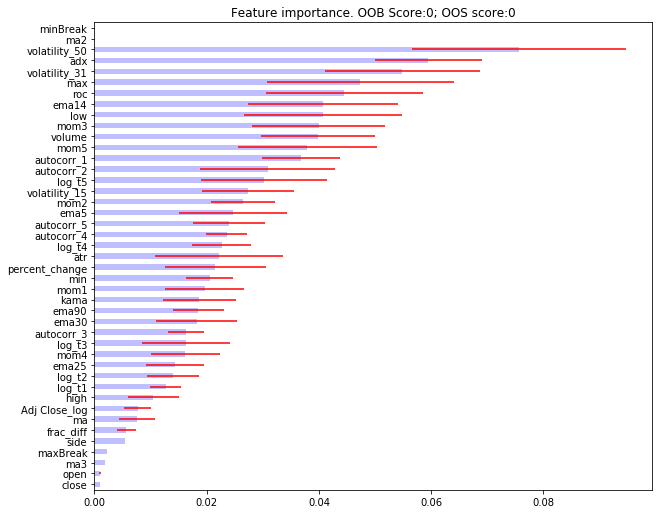

In [33]:
plot_feature_importance(mdi_feat_imp, 0, 0)


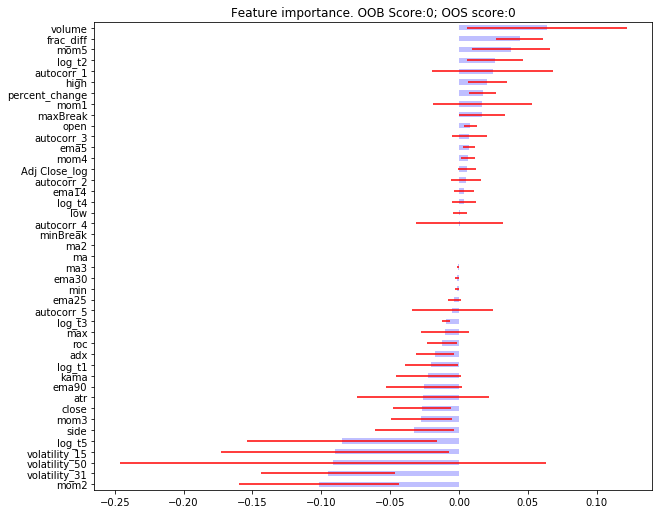

In [34]:
plot_feature_importance(mda_feat_imp, 0, 0)


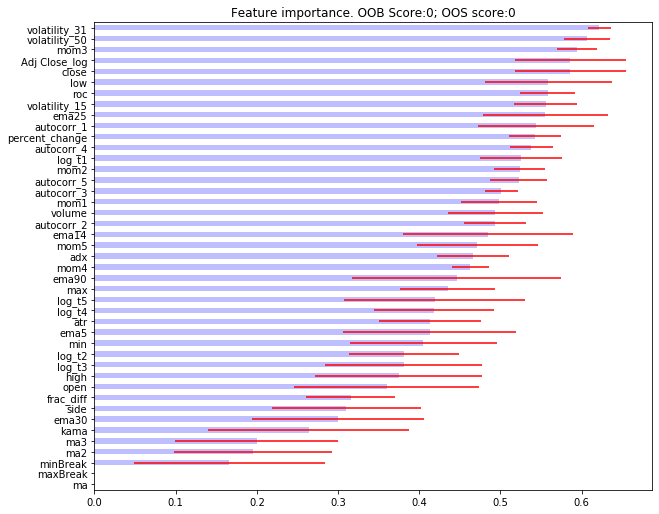

In [80]:
plot_feature_importance(sfi_feat_imp, 0, 0)

# PCA Analysis
### Compare top features above to PCA principals to determine which features are valid

In [81]:
pca_features = get_orthogonal_features(X_train)
pca = pd.DataFrame(data=pca_features)
pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-4.801268,0.545794,0.020624,-0.511404,2.243568,0.317506,-0.146785,-0.479313,0.582117,-0.102781,-0.750674,-0.234097,-0.370553,0.276792,-0.396463,-0.264922,-0.589951,-0.226661,-0.613049,-0.640108
1,-4.703011,-3.247772,0.551623,0.026440,2.275758,-0.249946,0.587747,-0.785030,-0.842295,-0.670656,0.894101,-0.086727,0.141123,-0.491401,0.734445,0.351705,0.137951,0.085417,0.136506,0.359127
2,-4.068398,-3.132442,0.373054,0.386087,1.806947,-0.424875,0.565800,-0.434311,-0.962250,-0.253482,1.037887,-0.333256,0.242202,-0.368732,-0.318567,-0.142836,-0.458445,-0.173926,-0.072662,0.376187
3,-4.025832,1.915497,0.344370,-0.371299,1.057951,-0.008088,0.071329,0.495460,0.905640,0.123843,-0.330020,0.273333,0.384816,0.008103,0.590318,-0.027267,0.746598,-1.039261,0.186255,0.534024
4,-3.699964,0.128499,0.087436,0.383413,0.053023,0.397316,2.950712,6.981779,1.383772,-1.323215,-1.682886,-3.264457,0.859572,-0.392404,-0.178373,1.374027,0.337251,-0.353917,1.550783,0.437032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,16.398720,1.782258,0.767294,-2.325854,4.031328,-2.272452,3.251357,-0.078313,0.640276,0.220496,-1.363003,1.393525,-1.094700,0.327051,-0.209417,0.679081,0.141345,-0.298730,-1.085488,0.841300
1564,16.088187,2.777227,0.158965,-1.714020,4.031713,-2.318717,3.236571,0.099577,0.202808,-1.222831,-0.568960,1.950931,-2.036386,-0.448936,-0.178142,0.329872,-0.017685,0.226878,-0.200621,0.025477
1565,16.083285,-0.528250,0.890779,-1.157632,4.275861,-0.687384,4.300742,-0.444930,0.874673,0.312800,-1.250649,1.326370,-1.361194,0.059635,-0.670213,0.315047,-0.201039,0.448144,0.371178,-0.206351
1566,15.904441,1.704132,-0.775178,0.049196,6.145739,-2.532100,3.067503,0.006414,0.808097,-0.073019,-1.312266,1.250652,-0.232376,0.010643,-0.780588,0.548909,1.057467,-0.580964,-0.257799,0.447076


In [82]:
mdi_feat_imp.fillna(0, inplace= True)

correlation_dict_mdi = feature_pca_analysis(X_train, mdi_feat_imp)
correlation_dict_mda = feature_pca_analysis(X_train, mda_feat_imp)
correlation_dict_sfi = feature_pca_analysis(X_train, sfi_feat_imp)

In [83]:
pd.DataFrame(correlation_dict_mdi)


,Pearson,Spearman,Kendall,Weighted_Kendall_Rank
0,0.003244,-0.05465,-0.037966,0.18717
1,0.924314,0.10926,0.099396,NaN


In [84]:
pd.DataFrame(correlation_dict_mda)


,Pearson,Spearman,Kendall,Weighted_Kendall_Rank
0,-0.009577,0.036813,0.023787,0.052363
1,0.779142,0.280866,0.302375,NaN


In [85]:
pd.DataFrame(correlation_dict_sfi)

,Pearson,Spearman,Kendall,Weighted_Kendall_Rank
0,-0.009053,0.036439,0.023481,0.055113
1,0.790938,0.285793,0.308152,NaN
